<a href="https://colab.research.google.com/github/YLiu95/Generative_AI/blob/main/Variational_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoder
MNIST VAE: Generating Handwritten Digits with a Variational Autoencoder

table of contents:

>[Variational Autoencoder](#updateTitle=true&folderId=1XSd5UBYT2zKmcLISn-xBRYa9upYgTaXM&scrollTo=jFGbuvlH33eh)

>>[device inspection](#updateTitle=true&folderId=1XSd5UBYT2zKmcLISn-xBRYa9upYgTaXM&scrollTo=hupchr4WHYH1)

>>[model construction](#updateTitle=true&folderId=1XSd5UBYT2zKmcLISn-xBRYa9upYgTaXM&scrollTo=ioW7n_byHbE4)

>>[training](#updateTitle=true&folderId=1XSd5UBYT2zKmcLISn-xBRYa9upYgTaXM&scrollTo=oHXAMZKlHjD_)

>>[image generation](#updateTitle=true&folderId=1XSd5UBYT2zKmcLISn-xBRYa9upYgTaXM&scrollTo=S53xTzcrHmyr)

>>[conclusion](#updateTitle=true&folderId=1XSd5UBYT2zKmcLISn-xBRYa9upYgTaXM&scrollTo=Wyw1IB3cINQ4)

>[end](#updateTitle=true&folderId=1XSd5UBYT2zKmcLISn-xBRYa9upYgTaXM&scrollTo=219egQCT_D6R)



## device inspection

In [1]:
import tensorflow as tf
print(tf.__version__)
tf.config.experimental.list_physical_devices(device_type=None)

2.12.0


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## model construction

In [2]:
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.datasets import mnist
from keras import backend as K
import numpy as np

# Load the MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize and reshape the data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Define the dimensions of the input image
input_dim = x_train.shape[1]

# Define the dimensions of the latent space
latent_dim = 2

# Define the size of the intermediate layers
hidden_dim = 256

# Define the encoder architecture
input_img = Input(shape=(input_dim,))
h = Dense(hidden_dim, activation='relu')(input_img)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

# Define the sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

# Define the latent space sampling layer
z = Lambda(sampling)([z_mean, z_log_var])

# Define the decoder architecture
decoder_h = Dense(hidden_dim, activation='relu')
decoder_mean = Dense(input_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# Define the VAE model
vae = Model(input_img, x_decoded_mean)

# Define the VAE loss function
reconstruction_loss = K.sum(K.binary_crossentropy(input_img, x_decoded_mean), axis=-1)
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

# Compile the model
vae.compile(optimizer='adam')

## training

In [3]:
%%time
# Train the model
with tf.device('GPU'):
    history = vae.fit(x_train, epochs=10, batch_size=128, validation_data=(x_test, None))

Epoch 1/10
469/469 [==============================] - 8s 6ms/step - loss: 218.1367 - val_loss: 182.6733
Epoch 2/10
469/469 [==============================] - 2s 4ms/step - loss: 176.6542 - val_loss: 171.8366
Epoch 3/10
469/469 [==============================] - 2s 4ms/step - loss: 169.7588 - val_loss: 168.0949
Epoch 4/10
469/469 [==============================] - 2s 4ms/step - loss: 167.1071 - val_loss: 166.2130
Epoch 5/10
469/469 [==============================] - 2s 4ms/step - loss: 165.4020 - val_loss: 164.6423
Epoch 6/10
469/469 [==============================] - 2s 5ms/step - loss: 163.9446 - val_loss: 163.1245
Epoch 7/10
469/469 [==============================] - 2s 5ms/step - loss: 162.6256 - val_loss: 161.9767
Epoch 8/10
469/469 [==============================] - 2s 4ms/step - loss: 161.2618 - val_loss: 160.7903
Epoch 9/10
469/469 [==============================] - 2s 4ms/step - loss: 160.0254 - val_loss: 159.4927
Epoch 10/10
469/469 [==============================] - 2s 4ms/st

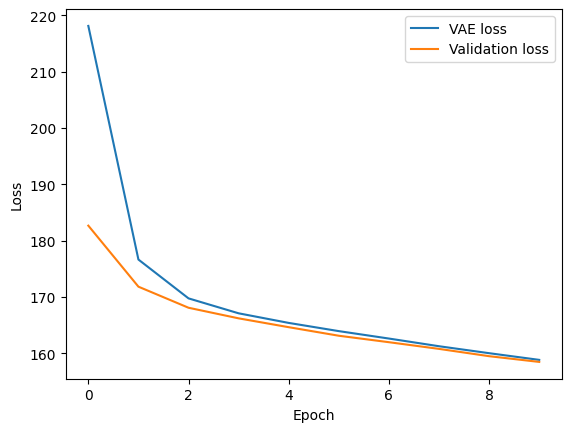

In [4]:
import matplotlib.pyplot as plt

# Plot the VAE loss and validation loss during training
plt.plot(history.history['loss'], label='VAE loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## image generation

1/1 [==============================] - 0s 110ms/step


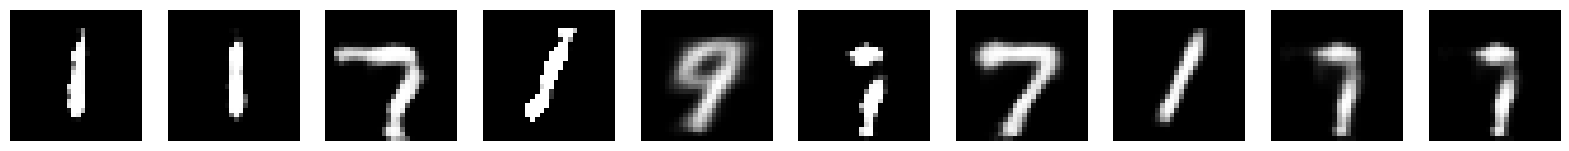

In [5]:
import matplotlib.pyplot as plt

# Define a function to generate new images
def generate_images(model, n=5):
    # Sample from the latent space
    z_sample = np.random.normal(size=(n, 784))
    # Use the decoder to generate new images
    x_decoded = model.predict(z_sample)
    # Reshape the images to their original dimensions
    x_decoded = x_decoded.reshape((n, 28, 28))
    # Plot the generated images
    fig, axes = plt.subplots(1, n, figsize=(20, 4))
    for i in range(n):
        axes[i].imshow(x_decoded[i], cmap='gray')
        axes[i].axis('off')
    plt.show()

# Generate 10 new images and visualize them
generate_images(vae, n=10)

compare to the original images

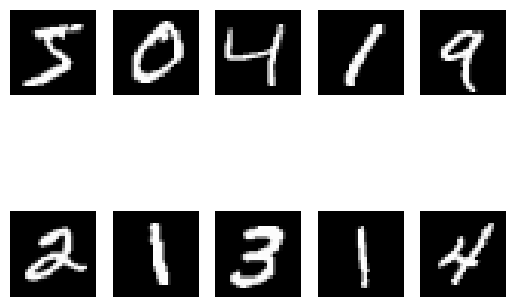

In [6]:
# Reshape the data back into its original shape
x_train_images = x_train.reshape(-1, 28, 28)

# Plot the first 10 images in x_train
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train_images[i], cmap='gray')
    plt.axis('off')

plt.show()

## conclusion

In conclusion, this project implemented a Variational Autoencoder (VAE) in Python using the Keras library. The VAE is trained on the MNIST dataset of handwritten digits and can be used to generate new, similar digits. The implementation includes: define the VAE model, compile it, and fit it to the data.

Overall, this project demostrated a solid foundation for understanding and working with VAEs.

# end